In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
#environment
import gym
import os
import time
#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
from math import sqrt
import copy


logging_interval = 40
animate_interval = logging_interval * 5
logdir='./DDPG/'
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
#env_name = 'InvertedDoublePendulum-v1'
env_name = 'Pendulum-v0'
#env_name = 'HalfCheetah-v1' 
#env_name = 'MountainCarContinuous-v0'
#env_name = 'Humanoid-v1'
#env_name = 'Ant-v1'



# wrap gym to save videos
env = gym.make(env_name)
env1 = gym.make(env_name)
env2 = gym.make(env_name)
env3 = gym.make(env_name)

if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env1 = gym.wrappers.Monitor(env1, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env1._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2018-06-05 16:23:18,172] Making new env: Pendulum-v0
[2018-06-05 16:23:18,314] Making new env: Pendulum-v0
[2018-06-05 16:23:18,316] Making new env: Pendulum-v0
[2018-06-05 16:23:18,317] Making new env: Pendulum-v0


In [2]:
class NormalizeAction(gym.ActionWrapper):
    def action(self, action):
        action = (action + 1) / 2  
        action *= (self.action_space.high - self.action_space.low)
        action += self.action_space.low
        return action

    def reverse_action(self, action):
        action -= self.action_space.low
        action /= (self.action_space.high - self.action_space.low)
        a
        ction = action * 2 - 1
        return actions

def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)
        
class OrnsteinUhlenbeckProcess:
    def __init__(self, mu=np.zeros(act_dim), sigma=0.05, theta=.25, dimension=1e-2, x0=None,num_steps=12000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dimension
        self.x0 = x0
        self.reset()

    def step(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [3]:
class AdaptiveParamNoiseSpec(object):
    def __init__(self, initial_stddev=0.1, desired_action_stddev=0.2, adaptation_coefficient=1.01):
        """
        Note that initial_stddev and current_stddev refer to std of parameter noise, 
        but desired_action_stddev refers to (as name notes) desired std in action space
        """
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adaptation_coefficient = adaptation_coefficient

        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            # Decrease stddev.
            self.current_stddev /= self.adaptation_coefficient
        else:
            # Increase stddev.
            self.current_stddev *= self.adaptation_coefficient

    def get_stats(self):
        stats = {
            'param_noise_stddev': self.current_stddev,
        }
        return stats

    def __repr__(self):
        fmt = 'AdaptiveParamNoiseSpec(initial_stddev={}, desired_action_stddev={}, adaptation_coefficient={})'
        return fmt.format(self.initial_stddev, self.desired_action_stddev, self.adaptation_coefficient)

def ddpg_distance_metric(actions1, actions2):
    """
    Compute "distance" between actions taken by two policies at the same states
    Expects numpy arrays
    """
    diff = actions1-actions2
    mean_diff = np.mean(np.square(diff), axis=0)
    dist = sqrt(np.mean(mean_diff))
    return dist


def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
           target_param.data.copy_(param.data)

In [4]:
import random

class Replay(object):
    def __init__(self, maxlen = 60000):
        self.maxlen = maxlen
        #self.data = deque(maxlen = self.maxlen)
        self.data=[]
        self.position=0
#         self.initialize(init_length=1000, envir=env)
        
    def initialize(self,init_length=1000, envir=env):
        s = envir.reset()
        for i in range (init_length):
            #a = np.random.random(1)-np.random.random(1)
            a = env.action_space.sample()
            s1, r, done, _ = env.step(a)            
            self.add((s,a,r,s1,done))
                        
            if done:
                s=envir.reset()
            else: 
                s = s1  
              
    def add(self, ep):
        self.data.append(ep)
        self.position = (self.position + 1) % self.maxlen       
        #self.data[self.position] = tuple(ep)
        
    def sample(self, batch_size):     
        return random.sample(self.data, batch_size)


In [5]:
class critic(nn.Module):

    def __init__(self, state_size, action_size, output_size = 1):
        super(critic, self).__init__()

        self.state_dim = state_size
        self.action_dim = action_size
        h1_dim = 300
        h2_dim = 300
        self.fc1 = nn.Linear(self.state_dim, h1_dim)
        #self.bn1 = nn.BatchNorm1d(h1_dim)
        self.fc2 = nn.Linear(h1_dim + self.action_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, output_size)

    def forward(self, state, action):
        #s1 = F.relu(self.bn1(self.fc1(state)))
        s1 = F.relu(self.fc1(state))
        x = torch.cat((s1,action), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class actor(nn.Module):

    def __init__(self, input_size, output_size):
        super(actor, self).__init__()

        self.state_dim = input_size
        self.action_dim = output_size
        h1_dim = 400
        h2_dim = 400
        self.fc1 = nn.Linear(self.state_dim, h1_dim)
        #self.bn1 = nn.BatchNorm1d(h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        #self.bn2 = nn.BatchNorm1d(h2_dim)
        self.fc3 = nn.Linear(h2_dim, self.action_dim)

    def forward(self, state):
        #x = F.relu(self.bn1(self.fc1(state)))
        #x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = F.tanh(self.fc3(x))
        return action

In [6]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_perturbed = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        if use_cuda:
            self.actor.cuda()
            self.actor_target.cuda()
            self.critic.cuda()
            self.critic_target.cuda()
            
        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)
    
    def action(self, s, noise, para):
        obs = torch.from_numpy(s).unsqueeze(0)
        inp = Variable(obs,requires_grad=False).type(FloatTensor)

        self.actor.eval()
        self.actor_perturbed.eval()

        if para is not None:
            a = self.actor_perturbed(inp).data[0].cpu().numpy() 
        else:
            a = self.actor(inp).data[0].cpu().numpy() 
        self.actor.train()

        if noise is not None:
            a = a + noise
        return a
    
    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name: 
                pass 
            param = params[name]
            random = torch.randn(param.shape)
            if use_cuda:
                random = random.cuda()
            param += random * param_noise.current_stddev
            
    def train(self, training_data):
        batch_s,batch_a,batch_r,batch_s1,batch_done=zip(*training_data)
        s1 = Variable(FloatTensor(batch_s))
        a1 = Variable(FloatTensor(batch_a))
        r1 = Variable(FloatTensor(np.array(batch_r).reshape(-1,1)))
        s2 = Variable(FloatTensor(batch_s1))
        d  = Variable(FloatTensor(1.0*np.array(batch_done).reshape(-1,1)))
        
        a2 = self.actor_target(s2)
        # ---------------------- optimize critic ----------------------
        next_val = self.critic_target(s2, a2).detach()
        q_expected = r1 + self.gamma*next_val*(1.0-d)
        q_predicted = self.critic(s1, a1)
        
        # compute critic loss, and update the critic
        loss_critic = self.critic_loss(q_predicted, q_expected)
        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()

        # ---------------------- optimize actor ----------------------
        pred_a1 = self.actor.forward(s1)
        loss_actor = -1*self.critic(s1, pred_a1)
        loss_actor = loss_actor.mean()
        
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        self.optimizer_actor.step()

        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

In [7]:
ddpg1 = DDPG(obs_dim = obs_dim, act_dim = act_dim)
ddpg2 = DDPG(obs_dim = obs_dim, act_dim = act_dim)
ddpg3 = DDPG(obs_dim = obs_dim, act_dim = act_dim)
memory = Replay(60000)
memory.initialize(init_length=150, envir=env)

In [8]:
#env = NormalizeAction(env) # remap action values for the environment
avg_val = 0


env1 = NormalizeAction(env1)
env2 = NormalizeAction(env2)
env3 = NormalizeAction(env3)

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_count = 0
total_rewards=[]
# set term_condition for early stopping according to environment being used
term_condition = -150 # Pendulum
#term_condition = 500 # inverted Pendulum
#term_condition = 8500 # half cheetah

param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05,desired_action_stddev=0.3, adaptation_coefficient=1.05)

for itr in range(NUM_EPISODES):
    s1 = env1.reset() # get initial state
    s2 = env2.reset()
    s3 = env3.reset()
    total_reward = [0, 0, 0]
    step_counter = [0,0,0]
    
    noise_counter=0
    ddpg1.perturb_actor_parameters(param_noise)
    ddpg2.perturb_actor_parameters(param_noise)
    ddpg3.perturb_actor_parameters(param_noise)
    
    done1 = 0
    done2 = 0
    done3 = 0
    
    while True:
        
        if not done1:
            ddpg1.noise.reset()
            a1 = ddpg1.action(s1, ddpg1.noise.step(), param_noise)
            s1_1, r1, done1, _ = env1.step(a1)
            memory.add((s1,a1,r1,s1_1,done1))
            total_reward[0] += r1
            step_counter[0] += 1
            training_data1 = np.array(memory.sample(BATCH_SIZE))
            ddpg1.train(training_data1)
            noise_counter += 1
            s1 = s1_1
            
        if not done2:
            ddpg2.noise.reset()
            a2 = ddpg2.action(s2, ddpg2.noise.step(), param_noise)
            
            s1_2, r2, done2, _ = env2.step(a2)
            memory.add((s2,a2,r2,s1_2,done2))
            total_reward[1] += r2
            step_counter[1] += 1
            training_data2 = np.array(memory.sample(BATCH_SIZE))
            ddpg2.train(training_data2)
            noise_counter += 1
            s2 = s1_2
            
        if not done3:
            ddpg3.noise.reset()
            a3 = ddpg3.action(s3, ddpg3.noise.step(), param_noise)
            
            s1_3, r3, done3, _ = env3.step(a3)
            memory.add((s3,a3,r3,s1_3,done3))
            total_reward[2] += r3
            
            step_counter[2] += 1
            training_data3 = np.array(memory.sample(BATCH_SIZE))
            ddpg3.train(training_data3)
            noise_counter += 1
            s3 = s1_3
            
        if done1 and done2 and done3:
            break
            
            
    ddpgs = [ddpg1, ddpg2, ddpg3]
    total_rewards.append(total_reward)
    idx = np.array(total_reward).argmax()
    myddpg = ddpgs[idx]

    ddpg1 = copy.deepcopy(myddpg)
    ddpg2 = copy.deepcopy(myddpg)
    ddpg3 = copy.deepcopy(myddpg)

    

    if memory.position-noise_counter > 0:
        noise_data=memory.data[memory.position-noise_counter:memory.position]
    else:
        noise_data=memory.data[memory.position-noise_counter+60000:60000] \
        + memory.data[0:memory.position]
        
    
    noise_data=np.array(noise_data)
    noise_s, noise_a, _,_ , _= zip(*noise_data)
    
    perturbed_actions = noise_a
    unperturbed_actions = myddpg.action(np.array(noise_s), None, None)
    ddpg_dist = ddpg_distance_metric(perturbed_actions, unperturbed_actions)
    param_noise.adapt(ddpg_dist)
    
    
    if itr > 3 and avg_val > term_condition:
        break
    running_rewards_ddpg.append(total_reward[idx]) # return of this episode
    step_count = step_count + step_counter[idx]
    step_list_ddpg.append(step_count)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))

    
    
    

Average value: -59.17589366444841 for episode: 0
Average value: -129.39551357833813 for episode: 1
Average value: -184.18362693663232 for episode: 2
Average value: -247.6766438742868 for episode: 3
Average value: -310.360487359077 for episode: 4
Average value: -372.9140529093967 for episode: 5
Average value: -432.0664276512963 for episode: 6
Average value: -482.30500192409073 for episode: 7
Average value: -532.3479170344112 for episode: 8
Average value: -579.7992236328215 for episode: 9
Average value: -621.7048377170886 for episode: 10
Average value: -661.748802401982 for episode: 11
Average value: -702.3619605979009 for episode: 12
Average value: -741.1153148503374 for episode: 13
Average value: -777.8317376796191 for episode: 14
Average value: -809.4815867478346 for episode: 15
Average value: -843.3157251538714 for episode: 16
Average value: -875.453662485577 for episode: 17
Average value: -900.8837351268967 for episode: 18
Average value: -925.5429532597178 for episode: 19
Average va

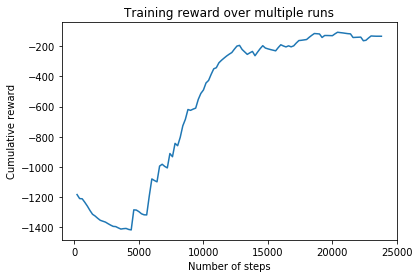

In [9]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

In [10]:
np.save('out.npy',out)
np.save('step_list_ddpg.npy',step_list_ddpg)

In [11]:
torch.save(myddpg.actor, 'actor.pt')
torch.save(myddpg.actor_perturbed, 'actor_perturbed.pt')
np.save('param_noise.npy',[param_noise.desired_action_stddev,
                           param_noise.adaptation_coefficient,
                           param_noise.current_stddev])

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
pnl = np.load('param_noise.npy')
myddpg.actor = torch.load('actor.pt')
myddpg.actor_perturbed = torch.load('actor_perturbed.pt')


In [18]:
env_name =  'Pendulum-v0'
env4 = gym.make(env_name)

# check whether the environment is discrete or continuous
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env4.observation_space.shape[0]
act_dim = env4.action_space.n if discrete else env.action_space.shape[0]
if discrete: print("This is a discrete action space, probably not the right algorithm to use")


logdir='./DDPG_final/'
logging_interval = 20
animate_interval = logging_interval * 5
VISUALIZE = True
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env4 = gym.wrappers.Monitor(env4, logdir, force=True, video_callable=lambda \
                               episode_id: episode_id%logging_interval==0)
env4._max_episodes_steps = MAX_PATH_LENGTH

env4 = NormalizeAction(env4) # remap action values for the environment

[2018-06-05 16:32:46,660] Making new env: Pendulum-v0


In [19]:
for i in range(2):
    SEED = 0   
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    s1 = env4.reset() # get initial state
    # env1.render()
    # time.sleep(0.05)
    count=0
    param_noise = AdaptiveParamNoiseSpec(pnl[2],pnl[0],pnl[1])
    while True: # for each episode, we loop each step in this episode
        myddpg.noise.reset()
        env4.render()
        time.sleep(0.05)
        # use actor to get action, add ddpg.noise.step() to action
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
        a1 = myddpg.action(s1, myddpg.noise.step(), param_noise)
        s1_1, r1, done1, _ = env4.step(a1)
        s1 = s1_1
        if done1: break
        count+=1
print('Finish Visualization')

[2018-06-05 16:32:47,135] Starting new video recorder writing to /datasets/home/04/004/l5shi/276_MA_Noise/pendulum/DDPG_final/openaigym.video.2.5315.video000000.mp4


Finish Visualization


In [20]:
count

199

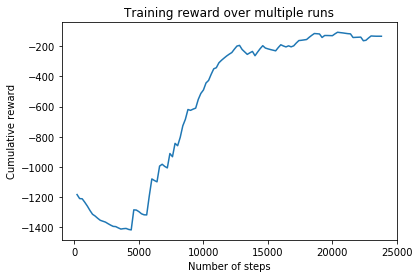

In [21]:
out=np.load('out.npy')
step_list_ddpg=np.load('step_list_ddpg.npy')

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()